## 🎯 **Strategy Overview**

The dual moving average crossover strategy is a classic trend-following strategy that uses two moving averages with different periods to capture market trends. When the fast moving average crosses above the slow moving average, it generates a long signal (Golden Cross). When the fast moving average crosses below the slow moving average, it generates a short signal (Death Cross).

## 🔧 **Key Features**

### **1. Flexible Implementation**
- **Moving Average Types**: Supports both SMA (Simple) and EMA (Exponential)
- **Customizable Periods**: Default 50/200-day combination, fully adjustable
- **Multiple Timeframes**: Works with any Yahoo Finance period (1d, 1mo, 1y, 2y, etc.)

### **2. Signal Generation**
- **Golden Cross**: Short-term MA crosses above long-term MA (bullish signal)
- **Death Cross**: Short-term MA crosses below long-term MA (bearish signal)
- **Position Tracking**: Maintains positions until opposite signal occurs

### **3. Performance Analytics**
- **Strategy vs. Buy & Hold** comparison
- **Win Rate** calculation
- **Sharpe Ratio** and volatility metrics
- **Maximum Drawdown** analysis
- **Trade-by-trade** performance tracking

### **4. Visualization**
- **Interactive Plotly charts** with 3-panel layout:
  - **Top Panel**: Price candlesticks + Moving Averages + Buy/Sell signals
  - **Middle Panel**: Position tracking over time
  - **Bottom Panel**: Cumulative returns comparison

## 📊 **Usage Examples**

The script includes three pre-configured examples:

1. **AAPL**: Classic 50/200 SMA (traditional Golden Cross)
2. **TSLA**: 50/200 EMA (more responsive to recent price changes)  
3. **NVDA**: 20/50 EMA (aggressive short-term strategy)

## 🔍 **Key Advantages**

### **Compared to Complex Strategies:**
- Simple and clear logic, easy to understand and implement
- Suitable for trending markets, can effectively capture medium and long-term market trends
- Adjustable parameters, suitable for different markets and trading instruments

### **Historical Performance:**
- According to research by Quantifiable Edges, the 50/200 day crossovers had the highest probability of success across timeframes studied
- Strategies based on the golden cross and death cross averaged gains of 7.43% over 40 days

## ⚠️ **Limitations to Consider**

In range-bound markets, frequent moving average crossovers may lead to frequent trading and increase transaction costs. The strategy works best in trending markets and may generate false signals during sideways price action.

## 🚀 **Getting Started**

Simply run the script with Python and it will:
1. Download data from Yahoo Finance
2. Calculate moving averages and generate signals
3. Compute comprehensive performance metrics
4. Display interactive charts
5. Print detailed analysis reports


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
from datetime import datetime, timedelta
from typing import Tuple, Dict, List, Optional

In [2]:
class DualMovingAverageStrategy:
    """
    Dual Moving Average Crossover Strategy Implementation
    
    This strategy uses two moving averages of different periods to generate trading signals:
    - Golden Cross: Short MA crosses above Long MA (Buy Signal)
    - Death Cross: Short MA crosses below Long MA (Sell Signal)
    
    Default parameters follow the classic 50-day and 200-day moving average combination
    """
    
    def __init__(self, short_period: int = 50, long_period: int = 200, ma_type: str = 'SMA'):
        """
        Initialize the Dual Moving Average Strategy
        
        Parameters:
        short_period (int): Period for the short-term moving average (default: 50)
        long_period (int): Period for the long-term moving average (default: 200)
        ma_type (str): Type of moving average ('SMA' for Simple, 'EMA' for Exponential)
        """
        self.short_period = short_period
        self.long_period = long_period
        self.ma_type = ma_type.upper()
        
        if self.ma_type not in ['SMA', 'EMA']:
            raise ValueError("ma_type must be either 'SMA' or 'EMA'")
        
        if short_period >= long_period:
            raise ValueError("Short period must be less than long period")
    
    def calculate_sma(self, series: pd.Series, period: int) -> pd.Series:
        """Calculate Simple Moving Average"""
        return series.rolling(window=period).mean()
    
    def calculate_ema(self, series: pd.Series, period: int) -> pd.Series:
        """Calculate Exponential Moving Average"""
        return series.ewm(span=period, adjust=False).mean()
    
    def calculate_moving_averages(self, data: pd.DataFrame) -> Dict[str, pd.Series]:
        """
        Calculate both short and long moving averages
        
        Parameters:
        data (pd.DataFrame): DataFrame with OHLC price data
        
        Returns:
        Dict containing short_ma and long_ma Series
        """
        close = data['Close']
        
        if self.ma_type == 'SMA':
            short_ma = self.calculate_sma(close, self.short_period)
            long_ma = self.calculate_sma(close, self.long_period)
        else:  # EMA
            short_ma = self.calculate_ema(close, self.short_period)
            long_ma = self.calculate_ema(close, self.long_period)
        
        return {
            'short_ma': short_ma,
            'long_ma': long_ma
        }
    
    def generate_signals(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Generate trading signals based on moving average crossovers
        
        Parameters:
        data (pd.DataFrame): DataFrame with OHLC price data
        
        Returns:
        pd.DataFrame: Original data with additional columns for MAs and signals
        """
        # Calculate moving averages
        mas = self.calculate_moving_averages(data)
        
        # Add moving averages to data
        result = data.copy()
        result[f'{self.ma_type}_{self.short_period}'] = mas['short_ma']
        result[f'{self.ma_type}_{self.long_period}'] = mas['long_ma']
        
        # Generate signals
        # Golden Cross: Short MA crosses above Long MA (Buy Signal)
        # Death Cross: Short MA crosses below Long MA (Sell Signal)
        
        result['Position'] = 0  # 0: No position, 1: Long, -1: Short
        result['Signal'] = None  # Buy, Sell, or None
        result['Cross_Type'] = None  # Golden_Cross, Death_Cross, or None
        
        # Calculate crossovers
        short_ma = mas['short_ma']
        long_ma = mas['long_ma']
        
        # Create boolean masks, handling NaN values properly
        short_above_long = (short_ma > long_ma).fillna(False)
        short_above_long_prev = short_above_long.shift(1).fillna(False)
        
        # Golden Cross: Short MA crosses above Long MA
        golden_cross = (short_above_long & ~short_above_long_prev)
        # Death Cross: Short MA crosses below Long MA  
        death_cross = (~short_above_long & short_above_long_prev)
        
        # Set signals
        result.loc[golden_cross, 'Signal'] = 'BUY'
        result.loc[golden_cross, 'Cross_Type'] = 'Golden_Cross'
        result.loc[golden_cross, 'Position'] = 1
        
        result.loc[death_cross, 'Signal'] = 'SELL'
        result.loc[death_cross, 'Cross_Type'] = 'Death_Cross'
        result.loc[death_cross, 'Position'] = -1
        
        # Forward fill positions (hold until next signal)
        result['Position'] = result['Position'].replace(0, np.nan).ffill().fillna(0)
        
        return result
    
    def calculate_performance_metrics(self, data: pd.DataFrame) -> Dict:
        """
        Calculate strategy performance metrics
        
        Parameters:
        data (pd.DataFrame): DataFrame with signals and prices
        
        Returns:
        Dict: Performance metrics
        """
        # Calculate returns
        data = data.copy()
        data['Price_Return'] = data['Close'].pct_change()
        data['Strategy_Return'] = data['Position'].shift(1) * data['Price_Return']
        data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()
        data['Buy_Hold_Return'] = (1 + data['Price_Return']).cumprod()
        
        # Performance metrics
        total_return = data['Cumulative_Return'].iloc[-1] - 1
        buy_hold_return = data['Buy_Hold_Return'].iloc[-1] - 1
        
        # Count signals
        buy_signals = (data['Signal'] == 'BUY').sum()
        sell_signals = (data['Signal'] == 'SELL').sum()
        
        # Calculate win rate (simplified)
        trades = data[data['Signal'].notna()].copy()
        if len(trades) > 1:
            trade_returns = []
            position = 0
            entry_price = 0
            
            for idx, row in trades.iterrows():
                if row['Signal'] == 'BUY' and position <= 0:
                    entry_price = row['Close']
                    position = 1
                elif row['Signal'] == 'SELL' and position >= 0:
                    if entry_price > 0:
                        trade_return = (row['Close'] - entry_price) / entry_price
                        trade_returns.append(trade_return)
                    position = -1
                    entry_price = row['Close']
                elif row['Signal'] == 'BUY' and position < 0:
                    if entry_price > 0:
                        trade_return = (entry_price - row['Close']) / entry_price
                        trade_returns.append(trade_return)
                    position = 1
                    entry_price = row['Close']
            
            win_rate = len([r for r in trade_returns if r > 0]) / len(trade_returns) if trade_returns else 0
            avg_return_per_trade = np.mean(trade_returns) if trade_returns else 0
        else:
            win_rate = 0
            avg_return_per_trade = 0
            trade_returns = []
        
        # Volatility metrics
        strategy_volatility = data['Strategy_Return'].std() * np.sqrt(252)
        buy_hold_volatility = data['Price_Return'].std() * np.sqrt(252)
        
        # Sharpe ratio (assuming 0% risk-free rate)
        sharpe_ratio = (data['Strategy_Return'].mean() * 252) / strategy_volatility if strategy_volatility > 0 else 0
        
        # Maximum drawdown
        cumulative = data['Cumulative_Return']
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'win_rate': win_rate,
            'total_trades': len(trade_returns),
            'buy_signals': buy_signals,
            'sell_signals': sell_signals,
            'avg_return_per_trade': avg_return_per_trade,
            'strategy_volatility': strategy_volatility,
            'buy_hold_volatility': buy_hold_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        }
    
    def plot_strategy(self, data: pd.DataFrame, symbol: str = 'Stock') -> go.Figure:
        """
        Create interactive Plotly chart showing the strategy
        
        Parameters:
        data (pd.DataFrame): DataFrame with signals and moving averages
        symbol (str): Symbol name for chart title
        
        Returns:
        plotly Figure object
        """
        fig = make_subplots(
            rows=3, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=[
                f'{symbol} - Dual Moving Average Crossover Strategy',
                'Position & Signals',
                'Cumulative Returns Comparison'
            ],
            row_heights=[0.5, 0.2, 0.3]
        )
        
        # Price chart with candlesticks
        fig.add_trace(
            go.Candlestick(
                x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Price',
                showlegend=False
            ),
            row=1, col=1
        )
        
        # Moving averages
        short_ma_col = f'{self.ma_type}_{self.short_period}'
        long_ma_col = f'{self.ma_type}_{self.long_period}'
        
        fig.add_trace(
            go.Scatter(
                x=data.index,
                y=data[short_ma_col],
                name=f'{short_ma_col}',
                line=dict(color='orange', width=2)
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=data.index,
                y=data[long_ma_col],
                name=f'{long_ma_col}',
                line=dict(color='blue', width=2)
            ),
            row=1, col=1
        )
        
        # Add buy/sell signals
        buy_signals = data[data['Signal'] == 'BUY']
        sell_signals = data[data['Signal'] == 'SELL']
        
        if not buy_signals.empty:
            fig.add_trace(
                go.Scatter(
                    x=buy_signals.index,
                    y=buy_signals['Close'],
                    mode='markers',
                    marker=dict(symbol='triangle-up', size=15, color='green'),
                    name='Golden Cross (Buy)',
                    showlegend=True
                ),
                row=1, col=1
            )
        
        if not sell_signals.empty:
            fig.add_trace(
                go.Scatter(
                    x=sell_signals.index,
                    y=sell_signals['Close'],
                    mode='markers',
                    marker=dict(symbol='triangle-down', size=15, color='red'),
                    name='Death Cross (Sell)',
                    showlegend=True
                ),
                row=1, col=1
            )
        
        # Position subplot
        fig.add_trace(
            go.Scatter(
                x=data.index,
                y=data['Position'],
                name='Position',
                line=dict(color='purple', width=2),
                fill='tonexty'
            ),
            row=2, col=1
        )
        
        # Cumulative returns comparison
        data_copy = data.copy()
        data_copy['Price_Return'] = data_copy['Close'].pct_change()
        data_copy['Strategy_Return'] = data_copy['Position'].shift(1) * data_copy['Price_Return']
        data_copy['Cumulative_Strategy'] = (1 + data_copy['Strategy_Return']).cumprod()
        data_copy['Cumulative_BuyHold'] = (1 + data_copy['Price_Return']).cumprod()
        
        fig.add_trace(
            go.Scatter(
                x=data_copy.index,
                y=data_copy['Cumulative_Strategy'],
                name='Strategy Returns',
                line=dict(color='green', width=2)
            ),
            row=3, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=data_copy.index,
                y=data_copy['Cumulative_BuyHold'],
                name='Buy & Hold',
                line=dict(color='gray', width=2)
            ),
            row=3, col=1
        )
        
        # Update layout
        fig.update_layout(
            title=f'{symbol} - Dual Moving Average Crossover Strategy',
            height=1000,
            showlegend=True,
            xaxis_rangeslider_visible=False
        )
        
        # Update y-axes
        fig.update_yaxes(title_text="Price", row=1, col=1)
        fig.update_yaxes(title_text="Position", row=2, col=1, range=[-1.1, 1.1])
        fig.update_yaxes(title_text="Cumulative Return", row=3, col=1)
        fig.update_xaxes(title_text="Date", row=3, col=1)
        
        return fig

In [3]:
def run_dual_ma_analysis(symbol: str, period: str = "2y", 
                        short_period: int = 50, long_period: int = 200, 
                        ma_type: str = 'SMA') -> Tuple[pd.DataFrame, Dict, go.Figure]:
    """
    Run complete dual moving average analysis for a given symbol
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL', 'TSLA')
    period (str): Data period (e.g., '1y', '2y', '5y')
    short_period (int): Short MA period (default: 50)
    long_period (int): Long MA period (default: 200)  
    ma_type (str): Moving average type ('SMA' or 'EMA')
    
    Returns:
    Tuple: (data_with_signals, performance_metrics, plotly_figure)
    """
    
    print(f"📊 Analyzing {symbol} with Dual Moving Average Strategy")
    print(f"Parameters: {short_period}-day {ma_type} / {long_period}-day {ma_type}")
    print("=" * 60)
    
    # Download data
    try:
        data = yf.download(symbol, period=period, progress=False, multi_level_index=False, auto_adjust=True)
        if data.empty:
            raise ValueError(f"No data found for symbol {symbol}")
            
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None, None, None
    
    # Initialize strategy
    strategy = DualMovingAverageStrategy(short_period, long_period, ma_type)
    
    # Generate signals
    data_with_signals = strategy.generate_signals(data)
    
    # Calculate performance
    performance = strategy.calculate_performance_metrics(data_with_signals)
    
    # Create plot
    fig = strategy.plot_strategy(data_with_signals, symbol)
    
    # Print results
    print("📈 PERFORMANCE SUMMARY")
    print("-" * 30)
    print(f"Strategy Return: {performance['total_return']:.2%}")
    print(f"Buy & Hold Return: {performance['buy_hold_return']:.2%}")
    print(f"Excess Return: {performance['excess_return']:.2%}")
    print(f"Win Rate: {performance['win_rate']:.2%}")
    print(f"Total Trades: {performance['total_trades']}")
    print(f"Sharpe Ratio: {performance['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {performance['max_drawdown']:.2%}")
    print(f"Strategy Volatility: {performance['strategy_volatility']:.2%}")
    
    print("\n🔄 SIGNAL SUMMARY")
    print("-" * 20)
    print(f"Golden Cross (Buy) Signals: {performance['buy_signals']}")
    print(f"Death Cross (Sell) Signals: {performance['sell_signals']}")
    
    # Recent signals
    recent_signals = data_with_signals[data_with_signals['Signal'].notna()].tail(5)
    if not recent_signals.empty:
        print("\n📅 RECENT SIGNALS")
        print("-" * 20)
        for date, row in recent_signals.iterrows():
            print(f"{date.strftime('%Y-%m-%d')}: {row['Cross_Type'].replace('_', ' ')} "
                  f"- {row['Signal']} at ${row['Close']:.2f}")
    
    # Current status
    current_position = data_with_signals['Position'].iloc[-1]
    current_price = data_with_signals['Close'].iloc[-1]
    current_short_ma = data_with_signals[f'{ma_type}_{short_period}'].iloc[-1]
    current_long_ma = data_with_signals[f'{ma_type}_{long_period}'].iloc[-1]
    
    print(f"\n📊 CURRENT STATUS")
    print("-" * 20)
    print(f"Current Price: ${current_price:.2f}")
    print(f"Current {short_period}-day {ma_type}: ${current_short_ma:.2f}")
    print(f"Current {long_period}-day {ma_type}: ${current_long_ma:.2f}")
    print(f"Current Position: {'LONG' if current_position > 0 else 'SHORT' if current_position < 0 else 'NEUTRAL'}")
    
    trend_status = "BULLISH 🟢" if current_short_ma > current_long_ma else "BEARISH 🔴"
    print(f"MA Trend: {trend_status}")
    
    return data_with_signals, performance, fig

In [20]:
data = yf.download("AAPL", period="2y", progress=False, multi_level_index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_25784\1706438559.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True



In [21]:
data.columns


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [22]:
pd.set_option('future.no_silent_downcasting', True)

🍎 APPLE (AAPL) - Classic 50/200 SMA Strategy
📊 Analyzing AAPL with Dual Moving Average Strategy
Parameters: 50-day SMA / 200-day SMA
📈 PERFORMANCE SUMMARY
------------------------------
Strategy Return: -30.43%
Buy & Hold Return: 12.39%
Excess Return: -42.81%
Win Rate: 0.00%
Total Trades: 1
Sharpe Ratio: -0.673
Max Drawdown: -43.20%
Strategy Volatility: 23.04%

🔄 SIGNAL SUMMARY
--------------------
Golden Cross (Buy) Signals: 203
Death Cross (Sell) Signals: 1

📅 RECENT SIGNALS
--------------------
2025-04-01: Golden Cross - BUY at $222.90
2025-04-02: Golden Cross - BUY at $223.60
2025-04-03: Golden Cross - BUY at $202.92
2025-04-04: Golden Cross - BUY at $188.13
2025-04-07: Death Cross - SELL at $181.22

📊 CURRENT STATUS
--------------------
Current Price: $211.16
Current 50-day SMA: $203.90
Current 200-day SMA: $222.41
Current Position: SHORT
MA Trend: BEARISH 🔴


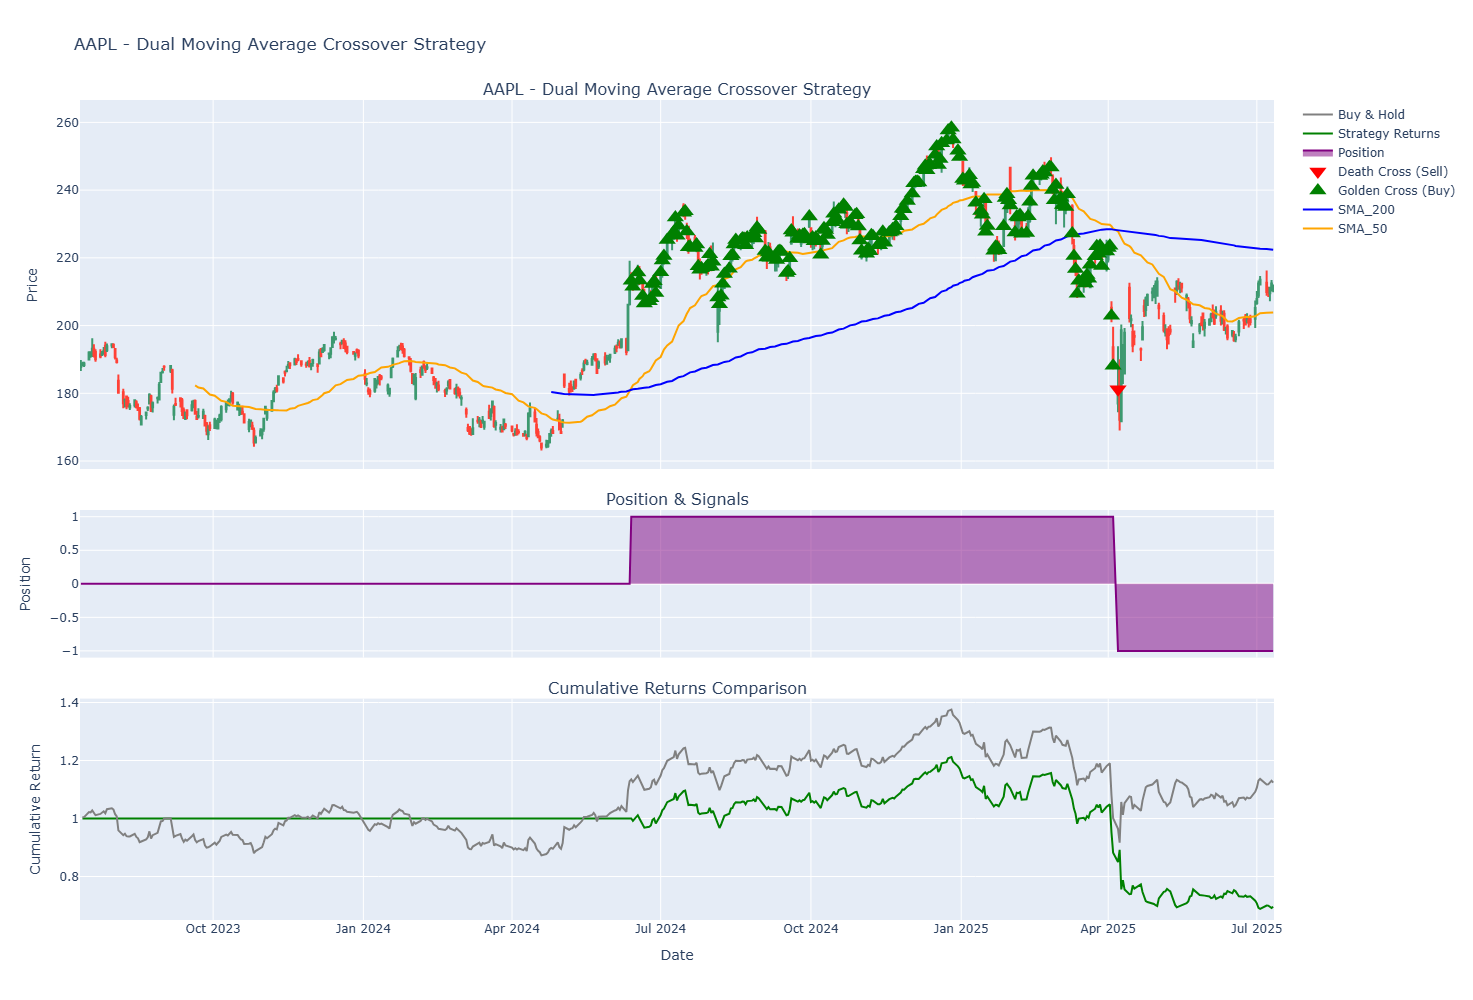

In [23]:
print("🍎 APPLE (AAPL) - Classic 50/200 SMA Strategy")
print("=" * 80)

data, performance, fig = run_dual_ma_analysis(
    symbol="AAPL",
    period="2y",
    short_period=50,
    long_period=200,
    ma_type='SMA'
)

if fig:
    fig.show()

🚗 TESLA (TSLA) - 50/200 EMA Strategy
📊 Analyzing TSLA with Dual Moving Average Strategy
Parameters: 50-day EMA / 200-day EMA
📈 PERFORMANCE SUMMARY
------------------------------
Strategy Return: -69.30%
Buy & Hold Return: 26.30%
Excess Return: -95.60%
Win Rate: 0.00%
Total Trades: 2
Sharpe Ratio: -1.237
Max Drawdown: -72.55%
Strategy Volatility: 73.66%

🔄 SIGNAL SUMMARY
--------------------
Golden Cross (Buy) Signals: 138
Death Cross (Sell) Signals: 2

📅 RECENT SIGNALS
--------------------
2025-07-07: Golden Cross - BUY at $293.94
2025-07-08: Golden Cross - BUY at $297.81
2025-07-09: Golden Cross - BUY at $295.88
2025-07-10: Golden Cross - BUY at $309.87
2025-07-11: Golden Cross - BUY at $313.51

📊 CURRENT STATUS
--------------------
Current Price: $313.51
Current 50-day EMA: $313.58
Current 200-day EMA: $304.04
Current Position: LONG
MA Trend: BULLISH 🟢


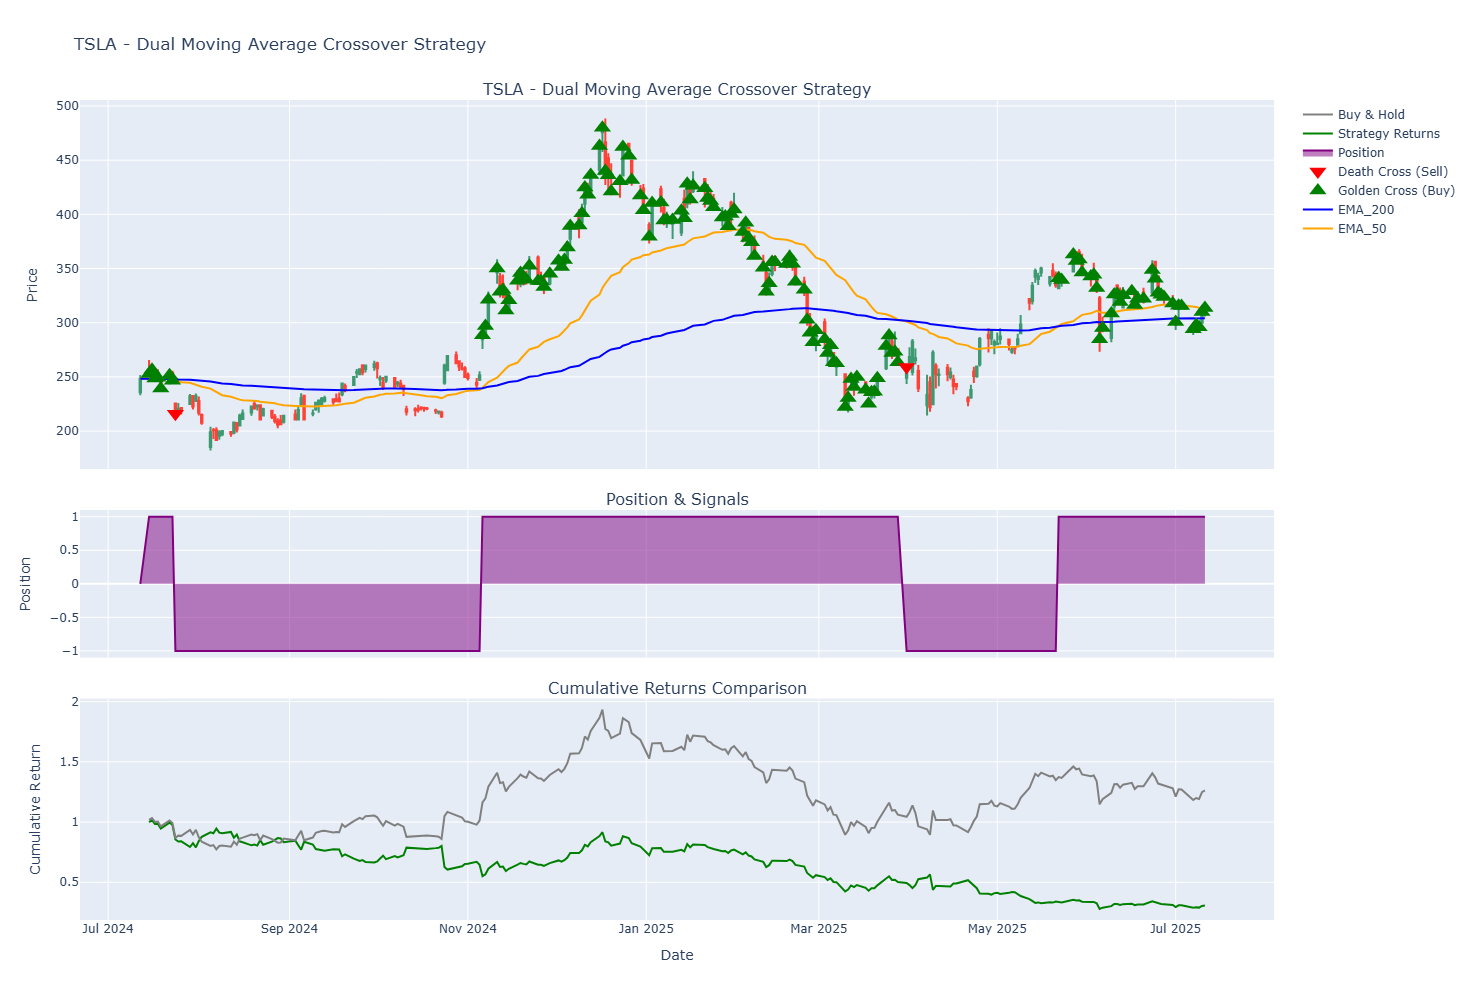

In [24]:
print("🚗 TESLA (TSLA) - 50/200 EMA Strategy")
print("=" * 80)

data2, performance2, fig2 = run_dual_ma_analysis(
    symbol="TSLA", 
    period="1y",
    short_period=50,
    long_period=200,
    ma_type='EMA'
)

if fig2:
    fig2.show()

print("\n" + "=" * 80)

⚡ NVIDIA (NVDA) - Aggressive 20/50 EMA Strategy
📊 Analyzing NVDA with Dual Moving Average Strategy
Parameters: 20-day EMA / 50-day EMA
📈 PERFORMANCE SUMMARY
------------------------------
Strategy Return: -6.66%
Buy & Hold Return: 27.65%
Excess Return: -34.30%
Win Rate: 50.00%
Total Trades: 2
Sharpe Ratio: 0.125
Max Drawdown: -36.66%
Strategy Volatility: 51.04%

🔄 SIGNAL SUMMARY
--------------------
Golden Cross (Buy) Signals: 119
Death Cross (Sell) Signals: 2

📅 RECENT SIGNALS
--------------------
2025-07-07: Golden Cross - BUY at $158.24
2025-07-08: Golden Cross - BUY at $160.00
2025-07-09: Golden Cross - BUY at $162.88
2025-07-10: Golden Cross - BUY at $164.10
2025-07-11: Golden Cross - BUY at $164.92

📊 CURRENT STATUS
--------------------
Current Price: $164.92
Current 20-day EMA: $154.13
Current 50-day EMA: $142.51
Current Position: LONG
MA Trend: BULLISH 🟢


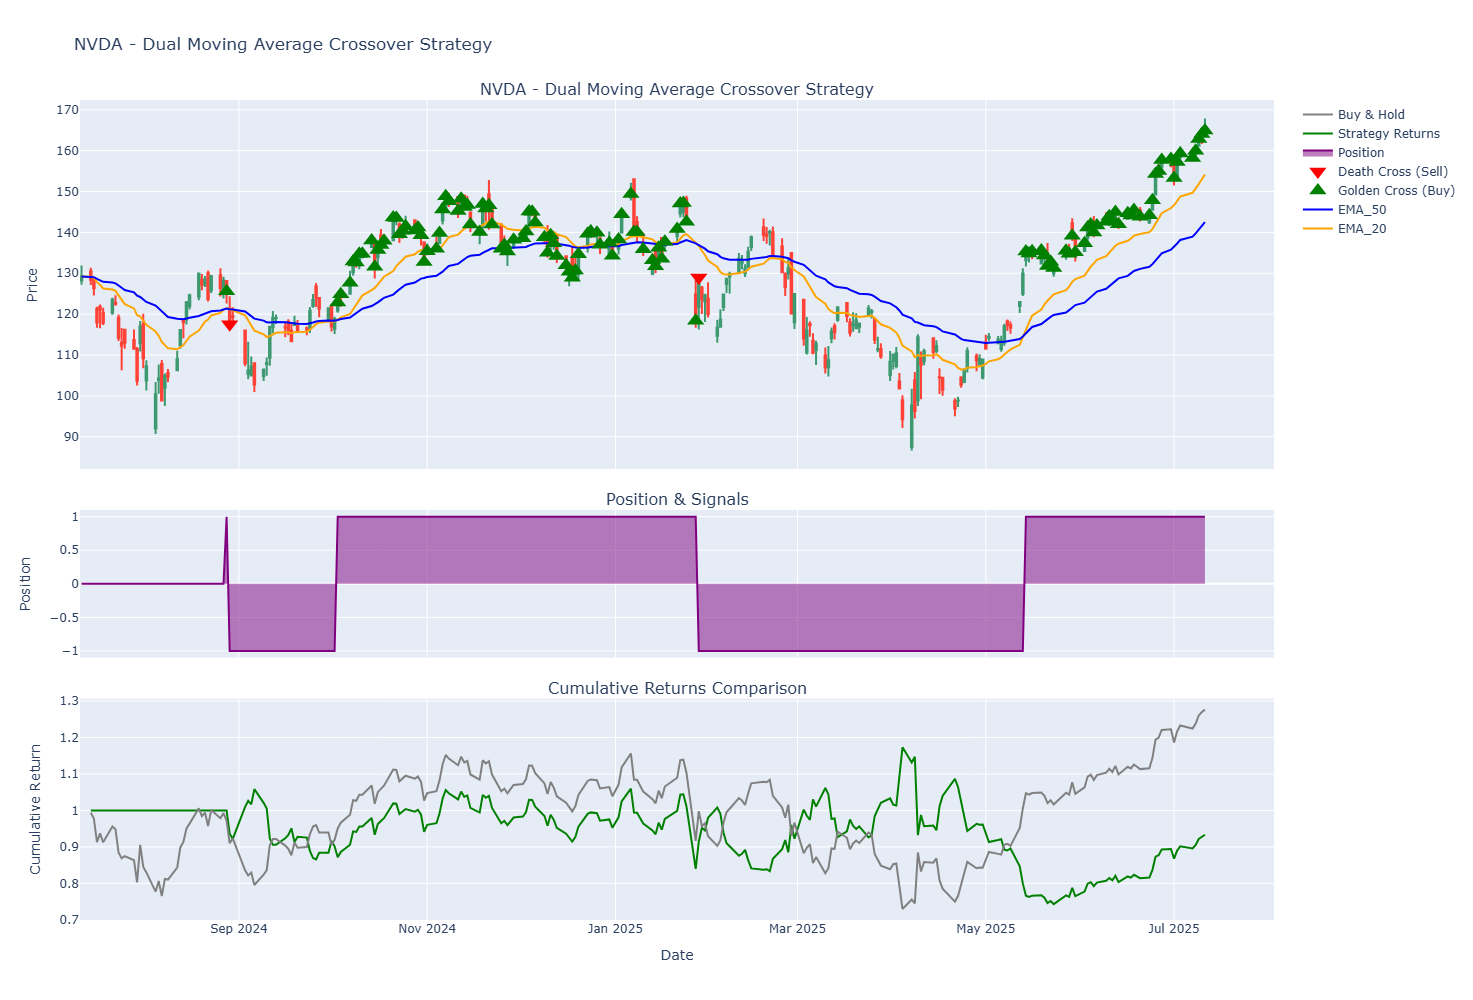

In [25]:
print("⚡ NVIDIA (NVDA) - Aggressive 20/50 EMA Strategy")
print("=" * 80)

data3, performance3, fig3 = run_dual_ma_analysis(
    symbol="NVDA",
    period="1y", 
    short_period=20,
    long_period=50,
    ma_type='EMA'
)

if fig3:
    fig3.show()